In [29]:
%load_ext autoreload
%autoreload 2

# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import logging
from tqdm import tqdm
from scipy.spatial.distance import euclidean

# Configure logging to show debug messages only from our project code
# Set root logger to WARNING to suppress debug from other libraries
logging.getLogger().setLevel(logging.WARNING)


# import the project root
sys.path.insert(0, '../..')
from src.covertree import CoverTree 
from src.dyadictree import DyadicTree
from src.dyadictreenode import DyadicTreeNode
from src.utils import *

from load_mnist import load_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# ========== NEW: Scikit-learn-like API Demo ==========

# Load fresh MNIST data for the demo
X_demo, original_shape_demo = load_dataset(flatten=True)

# Create a new CoverTree for clean demo
cover_tree_demo = CoverTree(X_demo, euclidean, leafsize=1)

# Create DyadicTree using NEW API (without fitting yet)
dyadic_sklearn = DyadicTree(
    cover_tree=cover_tree_demo,
    manifold_dims=0,      # Expected intrinsic dimension
    max_dim=X_demo.shape[-1],  # Maximum basis dimension  
    thresholds=0.0,       # Thresholds for basis construction
    precisions=1e-2,      # Precision parameters
    inverse=True          # Data in (n,d) format
)

# METHOD 1: Fit and transform separately (like sklearn.decomposition.PCA)
dyadic_sklearn.fit(X_demo)
coeffs_method1, leaf_indices_method1 = dyadic_sklearn.transform(X_demo)
X_recon_method1 = dyadic_sklearn.inverse_transform((coeffs_method1, leaf_indices_method1))

# Calculate reconstruction error
error_method1 = np.mean(np.linalg.norm(X_demo - X_recon_method1, axis=1))


info: making wavelet tree
info: making wavelets



4. Visualizing first 10 examples: Original vs Reconstructed


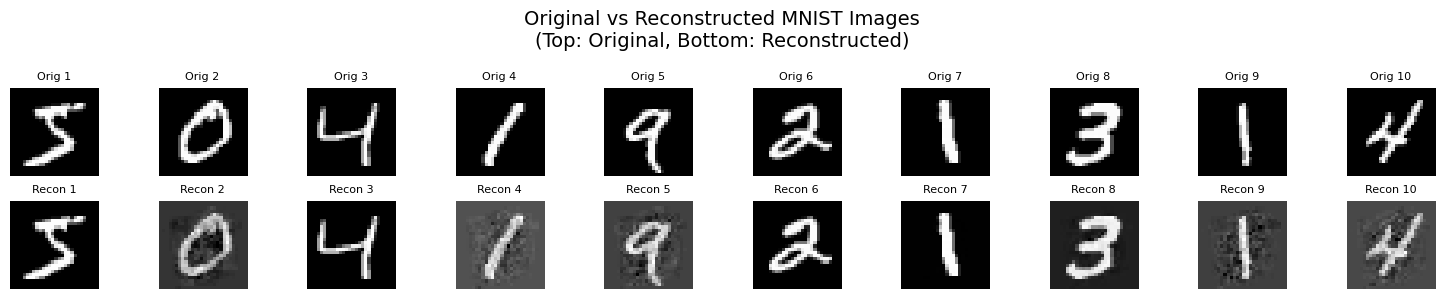

In [35]:
# ========== VISUALIZATION: Original vs Reconstructed Images ==========
print("\n4. Visualizing first 10 examples: Original vs Reconstructed")

# Reshape data back to image format (28x28 for MNIST)
X_demo_images = X_demo[:10].reshape(-1, 28, 28)
X_recon_images = X_recon_method1[:10].reshape(-1, 28, 28)

# Create subplot with 2 rows and 10 columns
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle('Original vs Reconstructed MNIST Images\n(Top: Original, Bottom: Reconstructed)', fontsize=14)

# Display original images in first row
for i in range(10):
    axes[0, i].imshow(X_demo_images[i], cmap='gray')
    axes[0, i].set_title(f'Orig {i+1}', fontsize=8)
    axes[0, i].axis('off')

# Display reconstructed images in second row
for i in range(10):
    axes[1, i].imshow(X_recon_images[i], cmap='gray')
    axes[1, i].set_title(f'Recon {i+1}', fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()